In [402]:
import random
import sys
from collections import Counter
from typing import Callable, Dict, List, Tuple

FeatureVector = Dict[str, int]
WeightVector = Dict[str, float]
Example = Tuple[FeatureVector, int]

def readExamples(filename):
    examples = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                text, label = parts
                examples.append((text, int(label)))
    return examples

def dotProduct(d1: Dict, d2: Dict) -> float:
    """
    @param dict d1: un vector de características representado por una asociación de característica (string) a peso (float).
    @param dict d2: igual que d1.
    @return float: el producto punto entre d1 y d2.
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in list(d2.items()))


def increment(d1: Dict, scale: float, d2: Dict):
    """
    Implementa d1 += scale * d2 para vectores dispersos.
    @param dict d1: el vector de características que es modificado.
    @param float scale: factor de escalamiento.
    @param dict d2: un vector de características.
    """
    for f, v in list(d2.items()):
        d1[f] = d1.get(f, 0) + v * scale


def readExamples(path: str):
    """
    Lee un conjunto de ejemplos de entrenamiento.
    """
    examples = []
    for line in open(path, "rb"):
        line = line.decode("latin-1")
        y, x = line.split(" ", 1)
        examples.append((x.strip(), int(y)))
    print("Read %d examples from %s" % (len(examples), path))
    return examples


def evaluatePredictor(
    examples: Tuple[FeatureVector, int], predictor: Callable
) -> float:
    """
    predictor: una función que toma una x y regresa una predicción y.
    Dada una lista de ejemplos (x, y), hace predicciones basadas en |predict| y regresa la fracción
    de ejemplos mal clasificados.
    """
    error = 0
    for x, y in examples:
        if predictor(x) != y:
            error += 1
    return 1.0 * error / len(examples)


def outputWeights(weights: WeightVector, path: str):
    print("%d weights" % len(weights))
    out = open(path, "w", encoding="utf8")
    for f, v in sorted(list(weights.items()), key=lambda f_v: -f_v[1]):
        print("\t".join([f, str(v)]), file=out)
    out.close()


def verbosePredict(phi: FeatureVector, y: int, weights: WeightVector, out) -> int:
    yy = 1 if dotProduct(phi, weights) >= 0 else -1
    if y:
        print(
            "Truth: %s, Prediction: %s [%s]"
            % (y, yy, "CORRECT" if y == yy else "WRONG"),
            file=out,
        )
    else:
        print("Prediction:", yy, file=out)
    for f, v in sorted(
        list(phi.items()), key=lambda f_v1: -f_v1[1] * weights.get(f_v1[0], 0)
    ):
        w = weights.get(f, 0)
        print("%-30s%s * %s = %s" % (f, v, w, v * w), file=out)
    return yy


def outputErrorAnalysis(
    examples: Tuple[FeatureVector, int],
    featureExtractor: Callable,
    weights: WeightVector,
    path: str,
):
    out = open(path, "w", encoding="utf-8")
    for x, y in examples:
        print("===", x, file=out)
        verbosePredict(featureExtractor(x), y, weights, out)
    out.close()


def interactivePrompt(featureExtractor: Callable, weights: WeightVector):
    while True:
        print("> ", end=" ")
        x = sys.stdin.readline()
        if not x:
            break
        phi = featureExtractor(x)
        verbosePredict(phi, None, weights, sys.stdout)


############################################################

def mini(x: list):
  for i in range(len(x)):
    if min(x) == x[i]:
      return i

def minimum(ls1: list, ls2: list):
  diference = list()
  for i in range(20):
    diference.append(abs(ls1[i]-ls2[i]))
  a = mini(diference)
  return a

In [294]:
import random
from typing import Callable, Dict, List, Tuple, TypeVar


FeatureVector = Dict[str, int]
WeightVector = Dict[str, float]
Example = Tuple[FeatureVector, int]


############################################################
# Problem 3: binary classification
############################################################

############################################################
# Problem 3a: feature extraction


def extractWordFeatures(x: str) -> FeatureVector:
    """
    Extrae características de palabras para una cadena x. Las palabras
    son delimitadas por espacios en blanco unicamente.
    @param string x:
    @return dict: representación en vector de características de x.
    Ejemplo: "I am what I am" --> {'I': 2, 'am': 2, 'what': 1}
    """
    # Inicio de tu código
    # Separamos por espacios
    words = x.split()
    # Definimos nuestro vector de caracteristicas como vacio
    feature_vector = {}
    for word in words:
        # Actualiza la letra en el vector de caracteristicas,
        # incrementandolo en 1 si ya existia en el diccionario,
        # o agregándolo con un valor de 1 si es la primera vez que aparece.
        feature_vector[word] = feature_vector.get(word, 0) + 1
    # Devolvemos el vector
    return feature_vector
    # Fin de tu código

############################################################
# Problem 3b: stochastic gradient descent


T = TypeVar("T")


def learnPredictor(
    trainExamples: List[Tuple[T, int]],
    validationExamples: List[Tuple[T, int]],
    featureExtractor: Callable[[T], FeatureVector],
    numEpochs: int,
    eta: float,
) -> WeightVector:
    """
    A partir de |trainExamples| y |validationExamples| (cada uno siendo una lista
    de parejas (x,y)), un |featureExtractor| para aplicar a x, y el número de
    épocas para entrenar |numEpochs|, el tamaño de paso |eta|, regresa el vector
    de pesos (vector de características disperas) aprendido.
    Debes implementar descenso de gradiente estocástico.
    Notas:
    - ¡Solo usa trainExamples para entrenar!
    - Debes llamar evaluatePredictor() sobre trainExamples y validationExamples para
    ver cómo te está llendo conforme aprendes después de cada época.
    - El predictor debe tener como salida +1 si el puntaje es precisamente 0.
    """
    weights = {}  # característica => peso
    # Inicio de tu código
    for epoch in range(numEpochs):
        for example, label in trainExamples:
            # vector de caracteristicas donde cada clave es una caracteristica
            # y cada valor es el peso asociado.
            features = featureExtractor(example)

            # activacion = w · phi(x)
            activation = dotProduct(weights, features)

            # Cuando el ejemplo de entrenamiento se clasifica incorrectamente actualiza los pesos.
            # Si la activación multiplicada por la etiqueta es mayor que cero, significa que el ejemplo se clasificó correctamente.
            if activation * label <= 0:
                increment(weights, eta * label, features)

        # Después de cada época de entrenamiento, se evalúa el desempeño,
        # sobre los datos de entrenamiento y validación.

        # En el primer parámetro pasamos los datos.
        # En el segundo parámetro si la función de articulación en la activación
        # (w · phi(x)) es mayor igual 0, significa que estamos clasificando
        # correctamente nuestra predicción por lo tanto devolvemos 1, de lo
        # contrario devolveremos -1.
        trainError = evaluatePredictor(trainExamples, lambda x: (
            1 if dotProduct(weights, featureExtractor(x)) >= 0 else -1))
        validationError = evaluatePredictor(validationExamples, lambda x: (
            1 if dotProduct(weights, featureExtractor(x)) >= 0 else -1))
    print(
        f"Epoch {epoch}: train error = {trainError:.10f}, validation error = {validationError:.10f}")
    # Fin de tu código
    return weights, trainError, validationError

############################################################
# Problem 3c: generate test case


def generateDataset(numExamples: int, weights: WeightVector) -> List[Example]:
    """
    Regresa un conjunto de ejemplos (phi(x), y) aleatoriamente que sean clasificados
    correctamente por |weights|.
    """
    random.seed(42)
    # Regresa un solo ejemplo (phi(x), y).
    # phi(x) debe ser un diccionario cuyas llaves sean un subconjunto de las
    # llaves en weights y los valores pueden ser cualquier cosa con un puntaje
    # para el vector de pesos dado.
    # y debe ser 1 o -1 como lo clasifica el vector de pesos.
    # y debe ser 1 si el puntaje es precisamente 0.

    # Nota que el vector de pesos puede ser arbitrario durante las pruebas.
    def generateExample() -> Tuple[Dict[str, int], int]:
        # Inicio de tu código
        phi = {}
        score = 0
        while score == 0:
            # Se selecciona un subconjunto aleatorio de las características en weights
            # y les asigna valores aleatorios.
            phi = {key: random.randint(-10, 10)
                   for key in weights.keys() if random.random() < 0.5}
            # Un margen mayor indica que el modelo de clasificación es más robusto.
            score = sum(weights[key] * phi[key] for key in phi)
        # Clasificación.
        y = 1 if score > 0 else -1
        # Fin de tu código
        return phi, y
    return [generateExample() for _ in range(numExamples)]

############################################################
# Problem 3d: character features


def extractCharacterFeatures(n: int) -> Callable[[str], FeatureVector]:
    """
    Regresa una función que tome una cadena |x| y regrese un vector de
    características disperso que consiste de todos los n-gramas de |x| sin
    espacios asociados a los conteos de n-gramas.
    EXAMPLE: (n = 3) "I like tacos" --> {'Ili': 1, 'lik': 1, 'ike': 1, ...
    Puedes suponer que n >= 1.
    """

    def extract(x: str) -> Dict[str, int]:
        # Inicio de tu código
        features = {}
        # Quitamos todos los espacios
        x = x.replace(" ", "")
        # El ciclo termina cuando ya no se puden crear mas n-gramas.
        # Ej. n = 3, x = "Holamundo" -> i < 7 -> Hol amu ndo
        for i in range(len(x) - n + 1):
            gram = x[i:i+n]
            # Actualiza el n-grama en el vector de caracteristicas,
            # incrementandolo en 1 si ya existia en el diccionario,
            # o agregándolo con un valor de 1 si es la primera vez que aparece.
            features[gram] = features.get(gram, 0) + 1
        return features
        # Fin de tu código
    return extract

############################################################
# Problem 3e:


def testValuesOfN(n: int):
    """
    Usa este código para probar distintos valores de n para extractCharacterFeatures
    Este código es exclusivo para las pruebas.
    Tu solución escrita completa debe estar en el archivo PDF.
    """
    trainExamples = readExamples("polarity.train")
    validationExamples = readExamples("polarity.dev")
    featureExtractor = extractCharacterFeatures(n)
    weights = learnPredictor(
        trainExamples, validationExamples, featureExtractor, numEpochs=20, eta=0.01
    )
    outputWeights(weights[0], "weights")
    outputErrorAnalysis(
        validationExamples, featureExtractor, weights[0], "error-analysis"
    )  # Usa esto para depurar
    trainError = evaluatePredictor(
        trainExamples,
        lambda x: (1 if dotProduct(featureExtractor(x), weights[0]) >= 0 else -1),
    )
    validationError = evaluatePredictor(
        validationExamples,
        lambda x: (1 if dotProduct(featureExtractor(x), weights[0]) >= 0 else -1),
    )
    print(
        (
            "Official: train error = %s, validation error = %s"
            % (trainError, validationError)
        )
    )
    return trainError, validationError

weights = learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 50, 0.01)

y = list()
for i in range(50):
  print(f"RealEpoch: {i}")
  new_weight = testValuesOfN(i)
  y.append(new_weight[1])

Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 49: train error = 0.0000000000, validation error = 0.2808103545
RealEpoch: 0
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 19: train error = 0.5019696117, validation error = 0.5073157006
1 weights
Official: train error = 0.501969611705121, validation error = 0.5073157006190209
RealEpoch: 1
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 19: train error = 0.4698930782, validation error = 0.4743950478
74 weights
Official: train error = 0.469893078221722, validation error = 0.4743950478334271
RealEpoch: 2
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 19: train error = 0.3556555993, validation error = 0.4347214406
1447 weights
Official: train error = 0.3556555993247046, validation error = 0.43472144063027574
RealEpoch: 3
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 19:

In [293]:
weights1 = [learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 1, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 2, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 3, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 4, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 5, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 6, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 7, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 8, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 9, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 10, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 11, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 12, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 13, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 14, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 15, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 16, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 17, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 18, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 19, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 20, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 21, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 22, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 23, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 24, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 25, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 26, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 27, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 28, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 29, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 30, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 31, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 32, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 33, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 34, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 35, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 36, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 37, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 38, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 39, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 40, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 41, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 42, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 43, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 44, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 45, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 46, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 47, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 48, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 49, 0.01),
            learnPredictor(readExamples("polarity.train"), readExamples("polarity.dev"), extractWordFeatures, 50, 0.01)]

Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 0: train error = 0.2355092853, validation error = 0.3359594823
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 1: train error = 0.1603826674, validation error = 0.3407428250
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 2: train error = 0.1347777153, validation error = 0.3308947665
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 3: train error = 0.1015756894, validation error = 0.3111986494
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 4: train error = 0.0869442881, validation error = 0.3086662915
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 5: train error = 0.0911648846, validation error = 0.3081035453
Read 3554 examples from polarity.train
Read 3554 examples from polarity.dev
Epoch 6: train error = 0.0953854811, validation error 

#extractCharacterFeatures

Se pueden experimentar diferentes valores de n y elegir el que produzca el menor error. En mi experimento, encontré que el valor de n = 4. Con valores de "n" más altos, se están considerando n-gramas más largos, lo que puede hacer que el modelo sea más específico a los datos de entrenamiento y, por lo tanto, menos generalizable a nuevos datos.

Es posible que se estén considerando combinaciones de caracteres que son muy poco frecuentes o incluso inexistentes en el conjunto de datos de entrenamiento. Esto puede hacer que el modelo produzca características poco útiles o incluso ruido, lo que puede empeorar el rendimiento del modelo.

In [404]:
x = [i for i in range(50)]
yyy = list()
xx = [i for i in range(50)]
for yy in range(50):
  yyy.append(weights1[yy][2])

Funcion extractCharactersFeatures
Minimo; n-gramas, valor: ( 4 ,  0.2940348902644907 )
Menor diferencia: ( 6 ,  0.30416432189082726 )


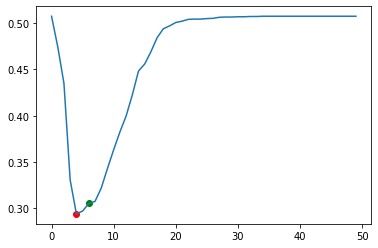

In [410]:
import matplotlib.pyplot as plt

plt.plot(x, y)
print("Funcion extractCharactersFeatures")
print("Minimo; n-gramas, valor: (", mini(y), ", ", y[mini(y)],")")
print("Menor diferencia: (", minimum(y, yyy), ", ", yyy[minimum(y, yyy)],")")
plt.scatter(mini(y), y[mini(y)], color='r')
plt.scatter(minimum(y, yyy), y[minimum(y, yyy)], color='g')


# extractWordsFeatures
En este experimento probe distinto número de epócas. se puede observar que conforme aumentamos las epócas nuestro error se aproxima a 0 pero despues de un número grande como 40 la gráfica se mantiene recta, significa que el modelo no está mejorando en términos de precisión de la predicción.

En la iteración 6 el error que produce el extractCharacterFeatures es casi tan pequeño como el de extractWordsFeatures

Funcion extractWordsFeatures
Minimo; Epóca, valor: ( 31 ,  0.2732132808103545 )
Menor diferencia: ( 6 ,  0.30416432189082726 )


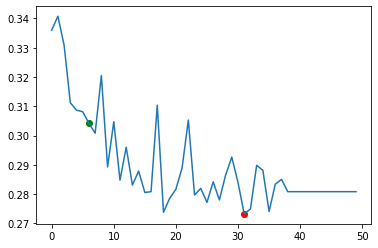

In [413]:
import matplotlib.pyplot as plt2

print("Funcion extractWordsFeatures")
print("Minimo; Epóca, valor: (", mini(yyy), ", ", min(yyy),")")
print("Menor diferencia: (", minimum(y, yyy), ", ", yyy[minimum(y, yyy)],")")
plt2.scatter(minimum(y, yyy), yyy[minimum(y, yyy)], color='g')
plt2.scatter(mini(yyy),min(yyy), color='r')
plt2.plot(xx, yyy)

Saber cuándo el error de extractCharactersFeatures es casi igual al error de extractWordsFeatures es útil porque puede indicar si el modelo está sobreajustando o no. Por lo tanto entre mas grande sea la diferencia de puntos entre las dos graficas, puede ser una señal de que el modelo esta ́sobreajustando.